#### Research question:
What factors motivate a consumer to make a purchase, and can we use those factors to identify potential customers?


#### Expected data sources:
Kaggle ecommerce data regarding customer profiles and purchasing information


#### Expected techniques:
CRISP–DM
Explore data, cluster analysis for classification of customer made purchase or did not, predictive model for predicting target customer, feature importance analysis to see what factors are most important to customers that make a purchase


#### Expected results:
I expect that there will be a few strong factors that influence the purchasing decision, I also expect that I will be able to target customers who fit the profile of these factors to make purchases


#### Why the question is important:
This question is important because understanding why a customer purchases is essential to marketing strategies and increasing profitability for a commerce company.

In [50]:
# importing libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report, confusion_matrix


### Data Loading

In [51]:
# loading the data - https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv
translation = pd.read_csv('data/product_category_name_translation.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')

In [52]:
# Merging data into one data set
products_enriched = products.merge(translation, on='product_category_name', how='left')

In [53]:
order_items_enriched = order_items.merge(products_enriched, on='product_id', how='left')

In [54]:
orders_customers = orders.merge(customers, on='customer_id', how='left')


In [55]:
order_items_orders_customers = order_items_enriched.merge(orders_customers, on='order_id', how='left')


In [56]:
complete_dataset = order_items_orders_customers.merge(reviews, on='order_id', how='left')


In [57]:
#investigating the complete dataset
complete_dataset.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,...,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,...,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,...,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,...,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,...,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59


### Data Exploration

In [58]:
complete_dataset.shape

(113314, 33)

In [59]:
#looking for null values
null_values = complete_dataset.isnull().sum()

null_values


order_id                             0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_category_name             1612
product_name_lenght               1612
product_description_lenght        1612
product_photos_qty                1612
product_weight_g                    18
product_length_cm                   18
product_height_cm                   18
product_width_cm                    18
product_category_name_english     1636
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   15
order_delivered_carrier_date      1203
order_delivered_customer_date     2475
order_estimated_delivery_date        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city            

In [60]:
#dropping columns unrelated to my analysis
columns_to_drop = [
    "order_id", "freight_value", "customer_zip_code_prefix", "order_item_id", "product_id", "seller_id", "shipping_limit_date",
    "product_name_lenght", "product_description_lenght", "product_photos_qty",
    "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm",
    "product_category_name", "customer_id", "order_status", "order_purchase_timestamp",
    "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date", "review_comment_title","review_comment_message","review_answer_timestamp","review_creation_date","review_id",
]

#Drop the specified columns
complete_dataset_dropped = complete_dataset.drop(columns=columns_to_drop, axis=1)
complete_dataset_dropped.head(5)


,price,product_category_name_english,customer_unique_id,customer_city,customer_state,review_score
0,58.90,cool_stuff,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes,RJ,5.0
1,239.90,pet_shop,eb28e67c4c0b83846050ddfb8a35d051,santa fe do sul,SP,4.0
2,199.00,furniture_decor,3818d81c6709e39d06b2738a8d3a2474,para de minas,MG,5.0
3,12.99,perfumery,af861d436cfc08b2c2ddefd0ba074622,atibaia,SP,4.0
4,199.90,garden_tools,64b576fb70d441e8f1b2d7d446e483c5,varzea paulista,SP,5.0


In [61]:
complete_dataset_dropped.isnull().sum()

price                               0
product_category_name_english    1636
customer_unique_id                  0
customer_city                       0
customer_state                      0
review_score                      942
dtype: int64

In [62]:
complete_dataset_dropped.shape

(113314, 6)

In [63]:
data = complete_dataset_dropped.dropna()

In [64]:
#investigating the data with no nulls
data.head(5)

,price,product_category_name_english,customer_unique_id,customer_city,customer_state,review_score
0,58.90,cool_stuff,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes,RJ,5.0
1,239.90,pet_shop,eb28e67c4c0b83846050ddfb8a35d051,santa fe do sul,SP,4.0
2,199.00,furniture_decor,3818d81c6709e39d06b2738a8d3a2474,para de minas,MG,5.0
3,12.99,perfumery,af861d436cfc08b2c2ddefd0ba074622,atibaia,SP,4.0
4,199.90,garden_tools,64b576fb70d441e8f1b2d7d446e483c5,varzea paulista,SP,5.0


In [65]:
data['product_category_name_english'].value_counts()

product_category_name_english
bed_bath_table                             11137
health_beauty                               9645
sports_leisure                              8640
furniture_decor                             8331
computers_accessories                       7849
housewares                                  6943
watches_gifts                               5950
telephony                                   4517
garden_tools                                4329
auto                                        4213
toys                                        4091
cool_stuff                                  3772
perfumery                                   3421
baby                                        3048
electronics                                 2749
stationery                                  2507
fashion_bags_accessories                    2039
pet_shop                                    1939
office_furniture                            1687
consoles_games                         

In [66]:
data['customer_city'].value_counts()

customer_city
sao paulo                           17496
rio de janeiro                       7660
belo horizonte                       3094
brasilia                             2370
curitiba                             1732
campinas                             1621
porto alegre                         1590
salvador                             1366
guarulhos                            1298
sao bernardo do campo                1046
niteroi                               971
santo andre                           878
osasco                                844
santos                                805
goiania                               766
sao jose dos campos                   761
fortaleza                             713
sorocaba                              696
recife                                661
florianopolis                         645
jundiai                               640
ribeirao preto                        579
nova iguacu                           490
contagem            

In [67]:
data['customer_state'].value_counts()

customer_state
SP    46730
RJ    14247
MG    12926
RS     6163
PR     5657
SC     4093
BA     3707
DF     2383
GO     2261
ES     2219
PE     1772
CE     1454
PA     1047
MT     1036
MS      820
MA      812
PB      586
PI      531
RN      521
AL      441
SE      381
TO      309
RO      271
AM      162
AC       90
AP       81
RR       50
Name: count, dtype: int64

Text(0.5, 1.0, 'Prices of Products')

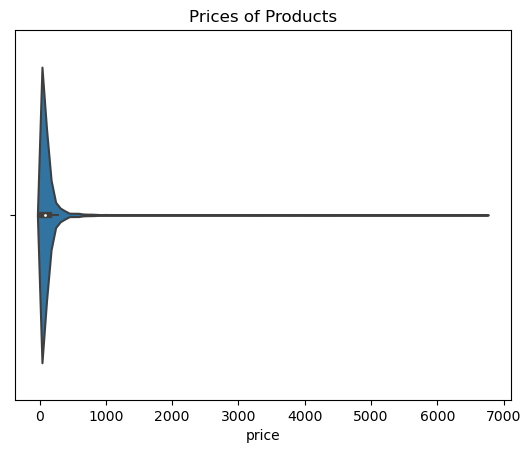

In [68]:
#Visualizing the different distributions
sns.violinplot(x=data["price"])
plt.title('Prices of Products')

Text(0.5, 1.0, 'Product Reviews')

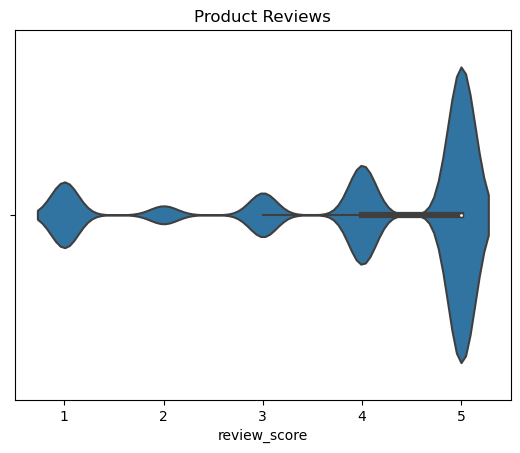

In [69]:
sns.violinplot(x=data["review_score"])
plt.title('Product Reviews')

In [70]:
top_customers = data['customer_unique_id'].value_counts().head(10)
top_customers

customer_unique_id
d97b3cfb22b0d6b25ac9ed4e9c2d481b    24
c8460e4251689ba205045f3ea17884a1    24
4546caea018ad8c692964e3382debd19    21
c402f431464c72e27330a67f7b94d4fb    20
0f5ac8d5c31de21d2f25e24be15bbffb    18
33176de67c05eeed870fd49f234387a0    15
11f97da02237a49c8e783dfda6f50e8e    15
eae0a83d752b1dd32697e0e7b4221656    15
8d50f5eadf50201ccdcedfb9e2ac8455    15
31e412b9fb766b6794724ed17a41dfa6    14
Name: count, dtype: int64

In [71]:
customer_distribution = data.groupby(['customer_state', 'customer_city']).size().reset_index(name='order_count')
customer_distribution = customer_distribution.sort_values(by='order_count', ascending=False)
customer_distribution.head(10)

,customer_state,customer_city,order_count
4147,SP,sao paulo,17496
2769,RJ,rio de janeiro,7660
1054,MG,belo horizonte,3094
599,DF,brasilia,2370
2390,PR,curitiba,1732
3701,SP,campinas,1621
3184,RS,porto alegre,1590
370,BA,salvador,1366
3808,SP,guarulhos,1298
4131,SP,sao bernardo do campo,1046


In [72]:
#investigating the categories 
category_order_counts = data['product_category_name_english'].value_counts()

most_ordered_categories = category_order_counts.head(10)
least_ordered_categories = category_order_counts.tail(10)

most_ordered_categories, least_ordered_categories

(product_category_name_english
 bed_bath_table           11137
 health_beauty             9645
 sports_leisure            8640
 furniture_decor           8331
 computers_accessories     7849
 housewares                6943
 watches_gifts             5950
 telephony                 4517
 garden_tools              4329
 auto                      4213
 Name: count, dtype: int64,
 product_category_name_english
 furniture_mattress_and_upholstery    38
 music                                38
 flowers                              31
 fashion_sport                        31
 home_comfort_2                       27
 arts_and_craftmanship                24
 cds_dvds_musicals                    14
 la_cuisine                           13
 fashion_childrens_clothes             8
 security_and_services                 2
 Name: count, dtype: int64)

In [73]:
pd.set_option('display.max_rows', None)
data['product_category_name_english'].value_counts()

product_category_name_english
bed_bath_table                             11137
health_beauty                               9645
sports_leisure                              8640
furniture_decor                             8331
computers_accessories                       7849
housewares                                  6943
watches_gifts                               5950
telephony                                   4517
garden_tools                                4329
auto                                        4213
toys                                        4091
cool_stuff                                  3772
perfumery                                   3421
baby                                        3048
electronics                                 2749
stationery                                  2507
fashion_bags_accessories                    2039
pet_shop                                    1939
office_furniture                            1687
consoles_games                         

In [74]:
#Setting category groups so data is easier to work with
category_groups = {
    'Electronics': ['computers_accessories', 'telephony', 'electronics', 'audio', 'computers', 'fixed_telephony'],
    'Fashion': ['fashion_bags_accessories', 'fashion_shoes', 'fashion_underwear_beach', 'fashion_male_clothing', 'fashio_female_clothing', 'fashion_childrens_clothes', 'fashion_sport'],
    'Home and Furniture': ['furniture_decor', 'home_appliances', 'small_appliances_home_oven_and_coffee', 'home_confort', 'home_comfort_2', 'furniture_bedroom', 'furniture_living_room', 'furniture_mattress_and_upholstery'],
    'Books and Media': ['books_general_interest', 'books_technical', 'books_imported', 'dvds_blu_ray', 'cds_dvds_musicals'],
    'Tools and Construction': ['construction_tools_construction', 'costruction_tools_tools', 'construction_tools_lights', 'construction_tools_safety', 'costruction_tools_garden'],
    'Other': ['security_and_services', 'arts_and_craftmanship', 'la_cuisine', 'diapers_and_hygiene', 'flowers', 'party_supplies', 'christmas_supplies', 'music']
}

In [75]:
def map_category(old_category):
    for new_category, old_categories in category_groups.items():
        if old_category in old_categories:
            return new_category
    return 'Miscellaneous' 

In [76]:
data.loc[:, 'combined_category'] = data['product_category_name_english'].apply(map_category)


/var/folders/gg/7b54qlg54fs2sb0jwbgrtfx00000gn/T/ipykernel_9085/3441109842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'combined_category'] = data['product_category_name_english'].apply(map_category)


In [77]:
datafinal = data.drop(columns=['product_category_name_english'])

In [78]:
#Encoding categorical variables
dataEncoded = pd.get_dummies(datafinal, columns=['customer_state', 'combined_category'])


In [79]:
dataEncoded.head(5)

,price,customer_unique_id,customer_city,review_score,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,...,customer_state_SE,customer_state_SP,customer_state_TO,combined_category_Books and Media,combined_category_Electronics,combined_category_Fashion,combined_category_Home and Furniture,combined_category_Miscellaneous,combined_category_Other,combined_category_Tools and Construction
0,58.90,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes,5.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,239.90,eb28e67c4c0b83846050ddfb8a35d051,santa fe do sul,4.0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
2,199.00,3818d81c6709e39d06b2738a8d3a2474,para de minas,5.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,12.99,af861d436cfc08b2c2ddefd0ba074622,atibaia,4.0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
4,199.90,64b576fb70d441e8f1b2d7d446e483c5,varzea paulista,5.0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False


In [80]:
target_encoder = TargetEncoder(smoothing=10)
dataEncoded['customer_city_target_enc'] = target_encoder.fit_transform(dataEncoded['customer_city'], dataEncoded['review_score'])


In [81]:
dataEncoded.drop(columns='customer_city', inplace=True)

In [82]:
dataEncoded.head(5)

,price,customer_unique_id,review_score,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,...,customer_state_SP,customer_state_TO,combined_category_Books and Media,combined_category_Electronics,combined_category_Fashion,combined_category_Home and Furniture,combined_category_Miscellaneous,combined_category_Other,combined_category_Tools and Construction,customer_city_target_enc
0,58.90,871766c5855e863f6eccc05f988b23cb,5.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,3.858268
1,239.90,eb28e67c4c0b83846050ddfb8a35d051,4.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,4.169972
2,199.00,3818d81c6709e39d06b2738a8d3a2474,5.0,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,4.025591
3,12.99,af861d436cfc08b2c2ddefd0ba074622,4.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,4.117318
4,199.90,64b576fb70d441e8f1b2d7d446e483c5,5.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,3.635895


### Clustering Analysis

In [83]:
#Preparing data for clustering
clustering_features = dataEncoded.drop(columns=['customer_unique_id', 'review_score'])


In [84]:
#Using k-means to cluser and determine optimal cluser number
sse_encoded = {}
for k in range(1, 5):
    kmeans_encoded = KMeans(n_clusters=k, random_state=42, n_init=10).fit(clustering_features)
    sse_encoded[k] = kmeans_encoded.inertia_

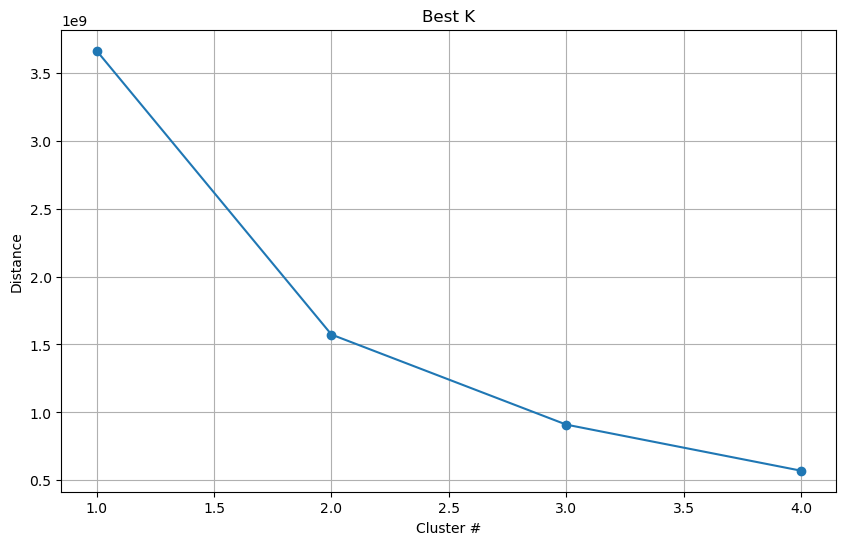

In [85]:
#Plotting the elbow method to visualize the k
plt.figure(figsize=(10, 6))
plt.plot(list(sse_encoded.keys()), list(sse_encoded.values()), marker='o')
plt.xlabel('Cluster #')
plt.ylabel('Distance')
plt.title('Best K')
plt.grid(True)
plt.show()

In [86]:
#Clustering with 3 clusters and decided by elbow visualization
kmeans = KMeans(n_clusters=3, random_state=42,n_init=10)
clustering_features['Cluster'] = kmeans.fit_predict(clustering_features)


In [87]:
#Analyzing the clusters, sum of data points in each
cluster_counts = clustering_features['Cluster'].value_counts()
cluster_percentages = clustering_features['Cluster'].value_counts(normalize=True) * 100

print("Cluster Counts:\n", cluster_counts)
print("\nCluster Percentages:\n", cluster_percentages)

Cluster Counts:
 Cluster
0    102358
1      7591
2       801
Name: count, dtype: int64

Cluster Percentages:
 Cluster
0    92.422573
1     6.854176
2     0.723251
Name: proportion, dtype: float64


### Predictive Modeling 

Now, I am moving on to predictive modeling - I am going to define the target variable as a review_score of 4 or above

In [88]:
dataEncoded.head(5)

,price,customer_unique_id,review_score,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,...,customer_state_SP,customer_state_TO,combined_category_Books and Media,combined_category_Electronics,combined_category_Fashion,combined_category_Home and Furniture,combined_category_Miscellaneous,combined_category_Other,combined_category_Tools and Construction,customer_city_target_enc
0,58.90,871766c5855e863f6eccc05f988b23cb,5.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,3.858268
1,239.90,eb28e67c4c0b83846050ddfb8a35d051,4.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,4.169972
2,199.00,3818d81c6709e39d06b2738a8d3a2474,5.0,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,4.025591
3,12.99,af861d436cfc08b2c2ddefd0ba074622,4.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,4.117318
4,199.90,64b576fb70d441e8f1b2d7d446e483c5,5.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,3.635895


In [89]:
#Definining the target variable
dataEncoded['Target'] = (dataEncoded['review_score'] >= 4).astype(int)

In [90]:
#Splitting data into X and y
X = dataEncoded.drop(columns=['Target','customer_unique_id','review_score'])
y = dataEncoded['Target']

In [91]:
#Splitting the data into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
#Setting up the model
model = LogisticRegression(random_state=123)
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=123)

In [93]:
#model predictions
lr_y_pred = model.predict(X_test)

In [94]:
#Evaluating the model with mean squared error
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_mse

0.24338600451467268

In [95]:
#Feature importance for the model
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": model.coef_[0]})
feature_importance = feature_importance.sort_values(by="Importance", key=lambda x: np.abs(x), ascending=False)
print(feature_importance)

                                     Feature  Importance
35                  customer_city_target_enc    0.887790
31      combined_category_Home and Furniture   -0.642896
28         combined_category_Books and Media    0.585090
32           combined_category_Miscellaneous   -0.577173
29             combined_category_Electronics   -0.567746
10                         customer_state_MA   -0.407603
6                          customer_state_CE   -0.349594
14                         customer_state_PA   -0.344093
19                         customer_state_RJ   -0.321775
34  combined_category_Tools and Construction   -0.280338
30                 combined_category_Fashion   -0.252433
25                         customer_state_SE   -0.155406
17                         customer_state_PI   -0.120265
5                          customer_state_BA   -0.113937
2                          customer_state_AL   -0.102088
33                   combined_category_Other   -0.097036
11                         cust

In [96]:
#decision tree
DTmodel = DecisionTreeClassifier(random_state=42)
DTmodel.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [97]:
#Evaluating the decision tree model
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.00      0.00      5393
           1       0.76      1.00      0.86     16757

    accuracy                           0.76     22150
   macro avg       0.75      0.50      0.43     22150
weighted avg       0.76      0.76      0.65     22150

[[    3  5390]
 [    1 16756]]


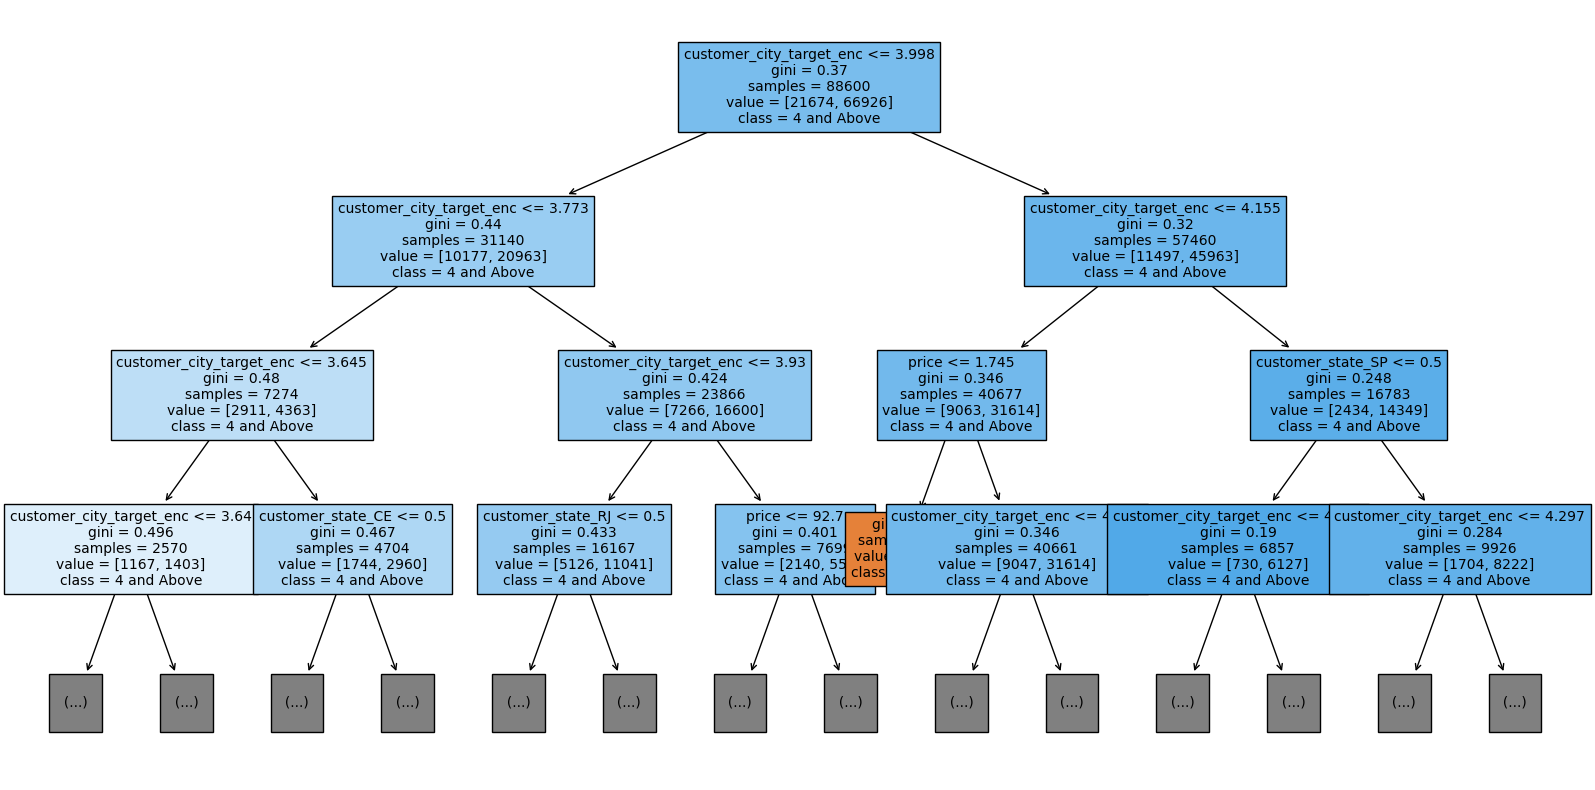

In [98]:
#Visualizing the decision tree model
plt.figure(figsize=(20,10))
plot_tree(DTmodel, filled=True, feature_names=X.columns, class_names=['Below 4', '4 and Above'], max_depth=3, fontsize=10)
plt.show()

### Findings

#### Customer Profile
- The average customer age is ~ 40 years old
- The average customer salary is about $58,000

#### Clustering 
- 92% of customers were in one cluster where the average income was around 60k and were moderate spenders

#### Predictive Model
- With 78% confidence we found that we are able to predict customer satisfaction (rating of above 4)
- The most important features in influencing the model were: Spending Score, Annual Income and Purchase History 

### Next Steps / Recommendations 

#### Enhance predictive models
- Improve regression to better predict customer satisfaction
 
#### Clustering
- Segement customers into clusters for marking campagins and other personalized approaches

#### Customer Data
- Continuously update data and models to reflect ordering 